In [ ]:

######################################################################
!pip install -q --upgrade diffusers
!pip install -q --upgrade transformers
!pip install -q --upgrade tokenizers
######################################################################
!pip install -q --upgrade peft
######################################################################
#!pip install diffusers==0.21.1 transformers==4.33.2 tokenizers==0.13.3
######################################################################

!pip install -q accelerate
!pip install -q safetensors
!pip install -q einops
!pip install -q onnxruntime-gpu
!pip install -q dlib
!pip install -q opencv-python
!pip install -q git+https://github.com/tencent-ailab/IP-Adapter.git

In [1]:
import torch
from diffusers.utils import load_image
from PIL import Image
import os


In [2]:

os.makedirs("images", exist_ok=True)
#!wget --continue https://upload.wikimedia.org/wikipedia/commons/0/0f/SDCC_2015_-_Gal_Gadot_%2819742671671%29_%28cropped%29.jpg -O images/gal_gadot_full_body.jpg
!wget --continue https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/1665_Girl_with_a_Pearl_Earring.jpg/800px-1665_Girl_with_a_Pearl_Earring.jpg -O images/Girl_with_a_Pearl_Earring.jpg

--2024-01-24 22:50:21--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/1665_Girl_with_a_Pearl_Earring.jpg/800px-1665_Girl_with_a_Pearl_Earring.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



exif problem, not rotating


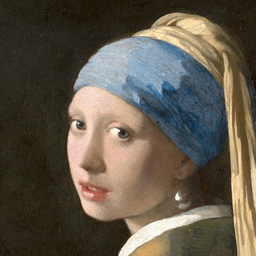

In [5]:
import crop_head_dlib5
# Detect and crop the head
#cropped_head = crop_head_dlib5.detect_and_crop_head("images/gal_gadot_full_body.jpg", factor=2.5)
cropped_head = crop_head_dlib5.detect_and_crop_head("images/Girl_with_a_Pearl_Earring.jpg", factor=4.5)
image = cropped_head.resize((256, 256))
image

In [6]:
vae_model_path = "stabilityai/sd-vae-ft-mse"

sd_model = "Norod78/sd15-simpsons-AV3-arthur-disneyPixar-mix-fp16"
#sd_model = "SG161222/Realistic_Vision_V5.1_noVAE"

image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
device = "cuda"

In [7]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from huggingface_hub import hf_hub_download
from diffusers.utils import load_image
from ip_adapter import IPAdapterFull
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1
)

vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
ip_ckpt = hf_hub_download(repo_id="h94/IP-Adapter", subfolder="models", filename="ip-adapter-full-face_sd15.bin", repo_type="model")

pipeline = StableDiffusionPipeline.from_pretrained(
    sd_model,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
).to("cuda")

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\doron\anaconda3\envs\py311\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
from ip_adapter import IPAdapterFull
# load ip-adapter
# They use 256 patch tokens and 1 cls token
ip_model = IPAdapterFull(pipeline, image_encoder_path, ip_ckpt, device, num_tokens=257)



  0%|          | 0/50 [00:00<?, ?it/s]

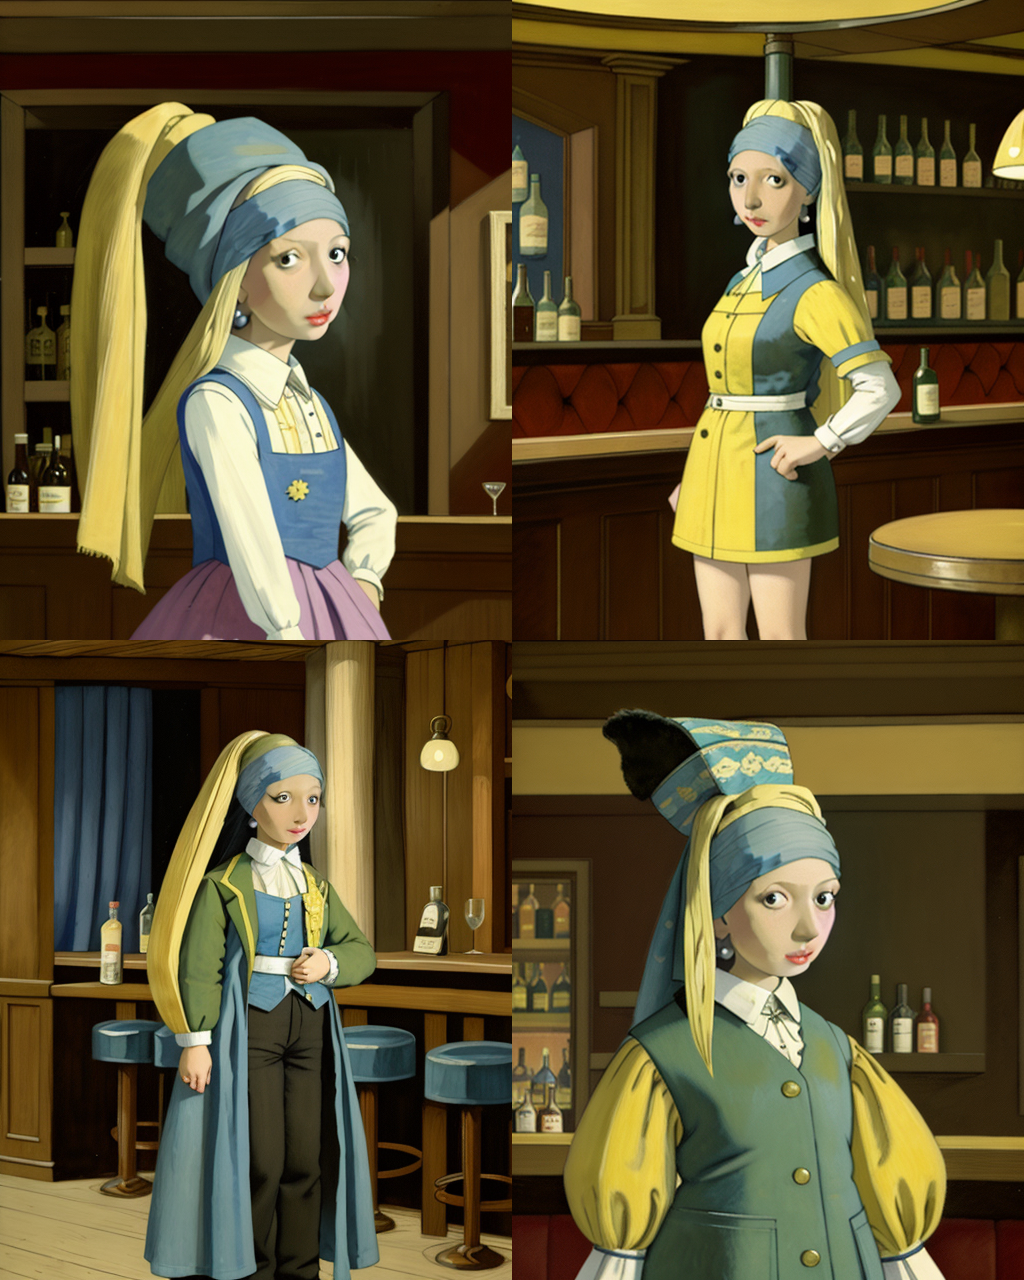

In [10]:
prompt = "full body photo of a standing woman wearing a fancy dress in a bar"
negative_prompt = "monochrome, lowres, bad anatomy, ,detached limbs, missing limbs, worst quality, low quality, blurry, extra limbs, nude, naked, nsfw"

images = ip_model.generate(
    prompt=prompt, negative_prompt=negative_prompt, pil_image=image, scale=0.85, guidance_scale=7.5, num_samples=4, width=512, height=640, num_inference_steps=50, seed=2024,
)

grid = image_grid(images, 2, 2)
grid
